In [1]:
%matplotlib inline

In [2]:
from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


In [3]:
import os

#  MDPL2-based mock
dirname = "/Users/aphearin/work/random/0331"
basename = "cutmock_1e9.hdf5"
fname = os.path.join(dirname, basename)

#  Bpl-based mock
# dirname = "/Users/aphearin/work/random/0331"
# basename = "testing_bpl_based_v4.hdf5"
# fname = os.path.join(dirname, basename)

from astropy.table import Table
mock = Table.read(fname, path='data')

#  Impute sSFR=0 values in the quenched sequence for plotting convenience
mock['obs_ssfr'] = mock['obs_sfr']/mock['obs_sm']
zero_mask = mock['obs_ssfr'] == 0
num_zeros = np.count_nonzero(zero_mask)
mock['obs_ssfr'][zero_mask] = 10**np.random.normal(loc=-13, scale=0.25, size=num_zeros)

print(mock.keys())



['halo_id', 'upid', 'vpeak', 'mpeak', 'mvir', 'vmax', 'sm', 'sfr', 'obs_sm', 'obs_sfr', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'hostid', 'host_halo_x', 'host_halo_y', 'host_halo_z', 'host_halo_vx', 'host_halo_vy', 'host_halo_vz', 'host_halo_mvir', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_sfr_percentile', 'sfr_percentile', 'obs_ssfr']


## Calculate initial Magr

In [4]:
from cosmodc2.sdss_colors import mock_magr


mstar_mock = mock['obs_sm']
sfr_percentile_mock = mock['sfr_percentile']
magr_sdss = sdss['restframe_extincted_sdss_abs_magr']
redshift_sdss = sdss['z']
logsm_sdss = sdss['sm'] 
sfr_percentile_sdss = sdss['sfr_percentile_fixed_sm']

mock['restframe_extincted_sdss_abs_magr'] = mock_magr(mstar_mock, sfr_percentile_mock,
          logsm_sdss, sfr_percentile_sdss, magr_sdss, redshift_sdss)

## Set up remapping functions

In [42]:
def prob_remap_bcg(upid, host_halo_mass,
            mhalo_table=(13.5, 13.75, 14, 15), prob_table=(0, 0.1, 0.5, 1)):
    """
    """
    ngals = len(upid)
    
    prob_remap = np.interp(np.log10(host_halo_mass), mhalo_table, prob_table)
    uran = np.random.rand(ngals)
    uran[upid != -1] = 1.0
    return uran < prob_remap

def prob_remap_highsm(upid, logsm, 
            logsm_table=(11, 11.25, 11.5), prob_table=(0, 0.5, 1)):
    """
    """
    ngals = len(upid)
    
    prob_remap = np.interp(logsm, logsm_table, prob_table)
    uran = np.random.rand(ngals)
    return uran < prob_remap

remap_bcg = prob_remap_bcg(mock['upid'], mock['host_halo_mvir'])
remap_highsm = prob_remap_highsm(mock['upid'], np.log10(mock['obs_sm']))
remapping_mask = remap_bcg | remap_highsm
num_to_remap = np.count_nonzero(remapping_mask)

In [44]:
from scipy.stats import binned_statistic

cenmask = mock['upid']==-1

sm_bins = np.logspace(10, 12, 40)
logsm_bins = np.log10(sm_bins)
sm_mids = 10**(0.5*(logsm_bins[:-1] + logsm_bins[1:]))
logsm_mids = np.log10(sm_mids)

median_magr, __, __ = binned_statistic(
    mock['obs_sm'][cenmask], mock['restframe_extincted_sdss_abs_magr'][cenmask], 
    bins=sm_bins, statistic='median')
std_magr, __, __ = binned_statistic(
    mock['obs_sm'][cenmask], mock['restframe_extincted_sdss_abs_magr'][cenmask], 
    bins=sm_bins, statistic=np.std)


from cosmodc2.sdss_colors import calculate_cluster_clf_powerlaw_coeffs

c0, c1 = calculate_cluster_clf_powerlaw_coeffs(
    mock['obs_sm'], mock['restframe_extincted_sdss_abs_magr'], mock['upid'])

median_new_magr = c0 + c1*np.log10(mock['obs_sm'])
mock['new_magr'] = mock['restframe_extincted_sdss_abs_magr']
mock['new_magr'][remapping_mask] = np.random.normal(
    loc=median_new_magr[remapping_mask], scale=0.35, size=num_to_remap)


from halotools.empirical_models import conditional_abunmatch
nwin = 301
x1 = mock['obs_sm']
y1 = mock['restframe_extincted_sdss_abs_magr']
x2 = mock['obs_sm']
y2 = mock['new_magr']

mock['cam_magr'] = conditional_abunmatch(x1, y1, x2, y2, nwin)

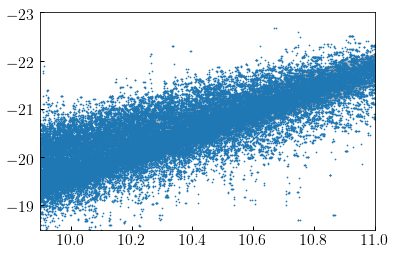

In [45]:
fig, ax = plt.subplots(1, 1)

ylow = median_magr - std_magr
yhigh = median_magr + std_magr

__=ax.fill_between(np.log10(sm_mids), ylow, yhigh, color='gray', alpha=0.5)

x = np.linspace(10, 12.5, 100)
y = c0 + 4*c1*x
__=ax.plot(x, y)

nskip = 30
# __=ax.scatter(np.log10(mock['obs_sm'][::nskip]), 
#                        mock['restframe_extincted_sdss_abs_magr'][::nskip], s=0.5)
__=ax.scatter(np.log10(mock['obs_sm'][::nskip]), 
                       mock['cam_magr'][::nskip], s=0.5)

ylim = ax.set_ylim(-18.5, -23)
xlim = ax.set_xlim(9.9, 11)

In [46]:
mask = (mock['obs_sm'] > 10**10.9) & (mock['obs_sm'] < 10**11.1)
np.std(mock['cam_magr'][mask])

0.34579380632851214

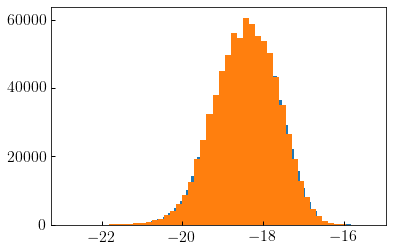

In [47]:
cenmask = mock['upid'] == -1
halo_mask = (mock['host_halo_mvir'] > 10**11.) & (mock['host_halo_mvir'] < 10**11.25)
np.std(mock['cam_magr'][cenmask & halo_mask])

fig, ax = plt.subplots(1, 1)

__=ax.hist(mock['cam_magr'][cenmask & halo_mask], bins=50)
__=ax.hist(mock['restframe_extincted_sdss_abs_magr'][cenmask & halo_mask], bins=50)



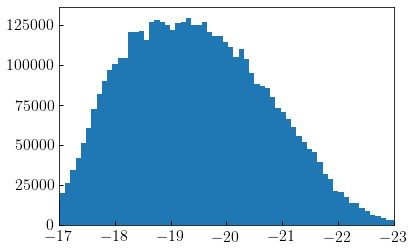

In [48]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(mock['cam_magr'], bins=100)
xlim = ax.set_xlim(-17, -23)

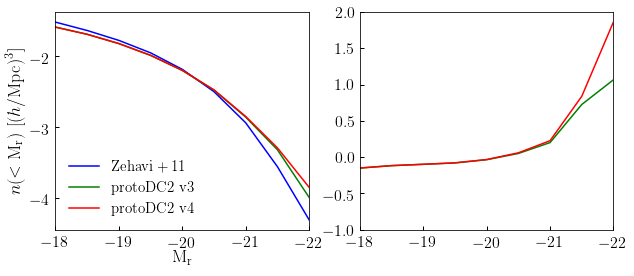

In [50]:
from cosmodc2.sdss_colors import zehavi11_cumulative_nd
lumthresh_h1p0, cumnd_sdss = zehavi11_cumulative_nd()

from cosmodc2.mock_diagnostics import cumulative_nd

volume_v4 = 500.**3.
protoDC2_littleh = 0.7
cumnd_pdc2_v3 = cumulative_nd(mock['restframe_extincted_sdss_abs_magr'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)
cumnd_pdc2_v4 = cumulative_nd(mock['cam_magr'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_sdss), label=r'${\rm Zehavi+11}$', color='blue')
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v3), 
            label=r'${\rm protoDC2\ v3}$', color='green')
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4), 
            label=r'${\rm protoDC2\ v4}$', color='red')

fracdiff_pdc2_v3 = (cumnd_pdc2_v3 - cumnd_sdss)/cumnd_sdss
fracdiff_pdc2_v4 = (cumnd_pdc2_v4 - cumnd_sdss)/cumnd_sdss
# fracdiff_pdc2_v4_model2 = (cumnd_pdc2_v4_model2 - cumnd_sdss)/cumnd_sdss
# fracdiff_pdc2_v4_model3 = (cumnd_pdc2_v4_model3 - cumnd_sdss)/cumnd_sdss
# fracdiff_pdc2_v3 = (cumnd_pdc2_v3 - cumnd_sdss)/cumnd_sdss

__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v3, 
            label=r'${\rm protoDC2\ v3}$', color='green')
__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4, 
            label=r'${\rm protoDC2\ v4}$', color='red')
# __=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4_model3, 
#             label=r'${\rm protoDC2\ v4\ model\ 3}$', color='red')
# __=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v3, ':', color='k', 
#             label=r'${\rm protoDC2\ v3}$')
# __=ax2.plot(np.linspace(-100, 100, 100), np.zeros(100), ':', color='k')

legend = ax1.legend()
xlabel = ax1.set_xlabel(r'${\rm M_{r}}$')
ylabel = ax1.set_ylabel(r'$n(<{\rm M_r})\ [(h/{\rm Mpc})^3]$')

xlim1 = ax1.set_xlim(-18, -22)
ylim2 = ax2.set_ylim(-1, 2)

## Compare luminosity threshold clustering to Zehavi+11

In [59]:
from cosmodc2.mock_diagnostics import zehavi_wp

period = 500.
x, y, z, vz = mock['x'], mock['y'], mock['z'], mock['vz']
magr = mock['cam_magr']

rp_mids, wp_v4_19p0 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh)
rp_mids, wp_v4_19p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh)
rp_mids, wp_v4_20p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh)
rp_mids, wp_v4_21p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh)


...downsampling sample from original counts = 1.89e+06
...calculating wp for 1.00e+05 galaxies and Mr < -19.0
...downsampling sample from original counts = 1.29e+06
...calculating wp for 1.00e+05 galaxies and Mr < -19.5
...downsampling sample from original counts = 4.22e+05
...calculating wp for 9.96e+04 galaxies and Mr < -20.5
...calculating wp for 6.44e+04 galaxies and Mr < -21.5


In [60]:
period = 500.
x, y, z, vz = mock['x'], mock['y'], mock['z'], mock['vz']
magr = mock['restframe_extincted_sdss_abs_magr']

rp_mids, wp_v3_19p0 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh)
rp_mids, wp_v3_19p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh)
rp_mids, wp_v3_20p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh)
rp_mids, wp_v3_21p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh)


...downsampling sample from original counts = 1.89e+06
...calculating wp for 1.00e+05 galaxies and Mr < -19.0
...downsampling sample from original counts = 1.29e+06
...calculating wp for 9.98e+04 galaxies and Mr < -19.5
...downsampling sample from original counts = 4.18e+05
...calculating wp for 9.98e+04 galaxies and Mr < -20.5
...calculating wp for 6.05e+04 galaxies and Mr < -21.5


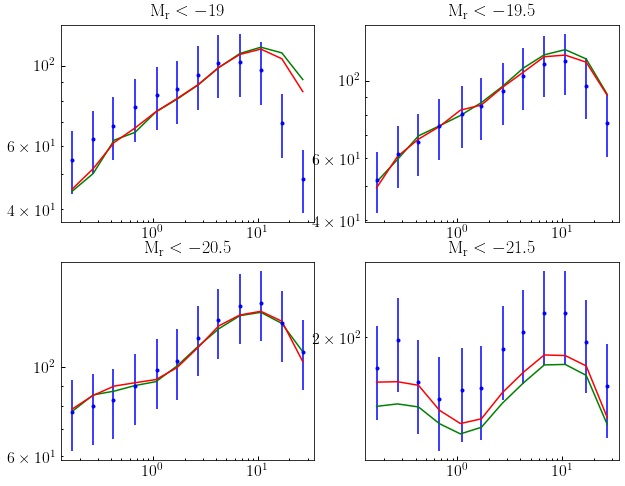

In [65]:
from cosmodc2.sdss_colors.sdss_measurements import rp as rp_zehavi
from cosmodc2.sdss_colors import zehavi11_clustering

wp_zehavi_18p5 = zehavi11_clustering(-18.5)
wp_zehavi_19p0 = zehavi11_clustering(-19.0)
wp_zehavi_19p5 = zehavi11_clustering(-19.5)
wp_zehavi_20p0 = zehavi11_clustering(-20.0)
wp_zehavi_20p5 = zehavi11_clustering(-20.5)
wp_zehavi_21p0 = zehavi11_clustering(-21.0)
wp_zehavi_21p5 = zehavi11_clustering(-21.5)

fig, _axes = plt.subplots(2, 2, figsize=(10, 8))
((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
for ax in axes:
    __=ax.loglog()


__=ax1.plot(rp_mids, rp_mids*wp_v3_19p0, color='green')
__=ax1.plot(rp_mids, rp_mids*wp_v4_19p0,  color='red')
__=ax1.errorbar(rp_zehavi, rp_zehavi*wp_zehavi_19p0, rp_zehavi*0.2*wp_zehavi_19p0, 
               fmt='.', color='blue')

__=ax2.plot(rp_mids, rp_mids*wp_v3_19p5, color='green')
__=ax2.plot(rp_mids, rp_mids*wp_v4_19p5,  color='red')
__=ax2.errorbar(rp_zehavi, rp_zehavi*wp_zehavi_19p5, rp_zehavi*0.2*wp_zehavi_19p5, 
               fmt='.', color='blue')

__=ax3.plot(rp_mids, rp_mids*wp_v3_20p5, color='green')
__=ax3.plot(rp_mids, rp_mids*wp_v4_20p5,  color='red')
__=ax3.errorbar(rp_zehavi, rp_zehavi*wp_zehavi_20p5, rp_zehavi*0.2*wp_zehavi_20p5, 
               fmt='.', color='blue')

__=ax4.plot(rp_mids, rp_mids*wp_v3_21p5, color='green')
__=ax4.plot(rp_mids, rp_mids*wp_v4_21p5,  color='red')
__=ax4.errorbar(rp_zehavi, rp_zehavi*wp_zehavi_21p5, rp_zehavi*0.2*wp_zehavi_21p5, 
               fmt='.', color='blue')


title1 = ax1.set_title(r'${\rm M_{r} < -19}$')
title2 = ax2.set_title(r'${\rm M_{r} < -19.5}$')
title3 = ax3.set_title(r'${\rm M_{r} < -20.5}$')
title4 = ax4.set_title(r'${\rm M_{r} < -21.5}$')


## Plot the cluster halo CLF

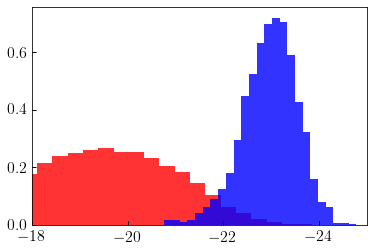

In [52]:
cenmask = mock['upid'] == -1
lowm, highm = 14., 14.25
halo_mask = (mock['host_halo_mvir'] > 10**lowm) & (mock['host_halo_mvir'] < 10**highm)


num_clusters = np.count_nonzero(cenmask & halo_mask)




fig, ax = plt.subplots(1, 1)

__=ax.hist(mock['cam_magr'][halo_mask & ~cenmask], 
           bins=25, normed=True, alpha=0.8, color='red')
__=ax.hist(mock['cam_magr'][halo_mask & cenmask], 
           bins=25, normed=True, alpha=0.8, color='blue')

xlim = ax.set_xlim(-18, -25)